In [37]:
import torch
import torch.nn.functional as F
from torch.nn.functional import cross_entropy
import matplotlib.pyplot as plt

In [38]:
words = open("names.txt","r").read().splitlines()

# make string to int and reverse mapping
chars = sorted(list(set(''.join(words)))) # gets unique chars (a,b,c...,y,z)
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0  # '.' char used to mark the start/end of a name
itos = {i:s for s,i in stoi.items()} # reverse mapping

In [39]:
import random
random.seed(42)
random.shuffle(words)

In [40]:
# Build Dataset

def build_dataset(words):
    block_size=3
    X,Y = [],[]
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context=context[1:]+[ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape,Y.shape)
    return X, Y


import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words)) # 80%
n2 = int(0.9*len(words)) # 10%

Xtr,Ytr = build_dataset(words[:n1]) # 80% training split
Xdev,Ydev = build_dataset(words[n1:n2]) # 10% dev split
Xte,Yte = build_dataset(words[n2:]) # 10% test split

torch.Size([182580, 3]) torch.Size([182580])
torch.Size([22767, 3]) torch.Size([22767])
torch.Size([22799, 3]) torch.Size([22799])


In [41]:
# Pytorch like abstraction
class Linear:
    def __init__(self,fan_in,fan_out, bias=True):
        self.weight = torch.randn((fan_in,fan_out))/ fan_in**0.5 # Kaiming initialization
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self,x): #forward pass
        self.out = x @ self.weight
        if self.bias is not None:
            self.out +=self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # trainable parameters
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # mean & var for when training=False
        self.running_mean=torch.zeros(dim)
        self.running_var=torch.ones(dim)

    def __call__(self, x): #forward pass
        if self.training:
            xmean = x.mean(0,keepdim=True)
            xvar = x.var(0,keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta

        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []

class Embedding:
    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim))

    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out

    def parameters(self):
        return [self.weight]

class Flatten:
    def __call__(self, x):
        self.out = x.view(x.shape[0],-1)
        return self.out

    def parameters(self):
        return[]

class Sequential:
    def __init__(self,layers):
        self.layers = layers

    def __call__(self,x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [42]:
torch.manual_seed(42);

In [43]:
n_embd = 20
n_hidden = 300
block_size = 3 # amount of context characters

model = Sequential([
    Embedding(27, n_embd),
    Flatten(),
    Linear(n_embd * block_size,n_hidden, bias=False),  # bias removed since BatchNorm cancels it
    BatchNorm1d(n_hidden),
    Tanh(),
    Linear(n_hidden,27)
])

with torch.no_grad():
    model.layers[-1].weight *= 0.1    # fixes high initial loss

parameters = model.parameters()
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad=True

27267


In [44]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # minibatch
    ix = torch.randint(0,Xtr.shape[0],(batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]

    # FORWARD PASS
    logits = model(Xb)

    # LOSS CALCULATION
    loss = cross_entropy(logits, Yb)  # this is equivalent to applying softmax to logits, then doing negative-log-likelihood loss calculation
    if i % 10000 == 0:
        print(f"Loss at {i}/200000: {loss.item()}")
    lossi.append(loss.log10().item())

    # zero_grad
    for p in parameters:
        p.grad = None

    # BACKWARD PASS
    loss.backward()

    # OPTIMIZE TRAINABLE PARAMETERS
    if i<50000:
        lr=0.1
    elif i<100000:
        lr=0.05
    else:
        lr=0.01
    for p in parameters:
        p.data += -lr * p.grad
print(f"Loss at 2000000/200000: {loss.item()}")

Loss at 0/200000: 3.2937097549438477
Loss at 10000/200000: 2.1001110076904297
Loss at 20000/200000: 2.3037033081054688
Loss at 30000/200000: 2.3493387699127197
Loss at 40000/200000: 2.063833236694336
Loss at 50000/200000: 2.2922329902648926
Loss at 60000/200000: 1.6169047355651855
Loss at 70000/200000: 1.9665753841400146
Loss at 80000/200000: 2.075759172439575
Loss at 90000/200000: 2.439479112625122
Loss at 100000/200000: 2.274813413619995
Loss at 110000/200000: 2.0719707012176514
Loss at 120000/200000: 2.2962145805358887
Loss at 130000/200000: 2.2899303436279297
Loss at 140000/200000: 2.091541290283203
Loss at 150000/200000: 2.1038475036621094
Loss at 160000/200000: 2.1763203144073486
Loss at 170000/200000: 2.376577138900757
Loss at 180000/200000: 2.3404595851898193
Loss at 190000/200000: 1.58842134475708
Loss at 2000000/200000: 2.087125539779663


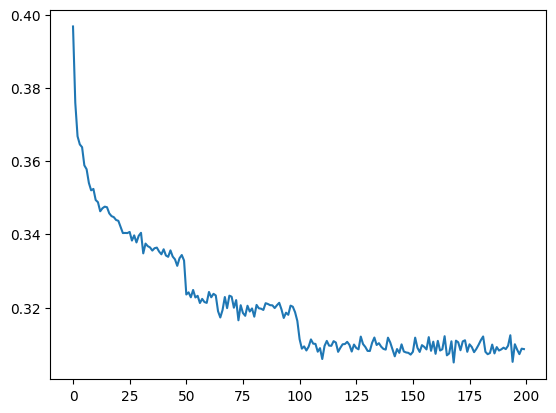

In [45]:
plt.plot(torch.tensor(lossi).view(-1,1000).mean(1))

In [46]:
for layer in model.layers:
    layer.training=False

In [47]:
@torch.no_grad()
def split_loss(split):
    x,y = {
        'train': (Xtr,Ytr),
        'dev': (Xdev,Ydev),
        'test': (Xte,Yte)
    }[split]

    logits = model(x)

    loss =  F.cross_entropy(logits,y)
    print(split, loss.item())

split_loss('train')
split_loss('dev')

train 2.016730785369873
dev 2.0879735946655273


In [48]:
# Test name generation for this model
block_size=3
def generate_name():
    out = []
    context = [0] * block_size  # start with '...' (0 = '.')

    while True:
        # forward pass
        x = torch.tensor([context])
        logits = model(x)
        probs = F.softmax(logits, dim=1)

        # sample next character
        ix = torch.multinomial(probs, num_samples=1).item()

        # update context
        context = context[1:] + [ix]
        out.append(ix)

        if ix == 0:  # end token '.'
            break
    return ''.join(itos[i] for i in out)

for _ in range(20):
    name = generate_name()
    print(name)

khail.
cayreenica.
brytter.
emell.
kryson.
emmy.
alziel.
kora.
naton.
cultaedanish.
carmeni.
jhraysinasia.
mah.
jeena.
braynan.
hadlou.
arrey.
jacereanta.
romee.
likaas.
